# Building and Evaluating a Chatbot
In this notebook, we will use the BioASQ dataset to build a chatbot specialized in biomedical knowledge and then evaluate its results using the test dataset.

## Setup

In [4]:
import pandas as pd
import os
from openai import AzureOpenAI

In [7]:
from datasets import load_dataset

knowledge_base = load_dataset("rag-datasets/mini-bioasq",'text-corpus')
test = load_dataset("rag-datasets/mini-bioasq",'question-answer-passages')

In [8]:
#os.environ["AZURE_OPENAI_API_KEY"]="a17443826ad74e2b89b7b1176db56a7" 
#os.environ["AZURE_OPENAI_ENDPOINT"] = "https://novaimsplayground.openai.azure.com/" 

In [9]:
knowledge_base=pd.DataFrame(knowledge_base)
knowledge_base['passages']=knowledge_base['passages'].apply(lambda x: x['passage'])
knowledge_base.head()

,passages
0,New data on viruses isolated from patients wit...
1,We describe an improved method for detecting d...
2,We have studied the effects of curare on respo...
3,Kinetic and electrophoretic properties of 230-...
4,Male Wistar specific-pathogen-free rats aged 2...


In [10]:
knowledge_base[knowledge_base["passages"]=='nan']

,passages
11,nan
12,nan
13,nan
14,nan
15,nan
...,...
40198,nan
40199,nan
40200,nan
40201,nan


In [11]:
knowledge_base=knowledge_base[knowledge_base["passages"]!='nan']

In [12]:
test=pd.DataFrame(test)
test['question']=test['test'].apply(lambda x:x['question'])
test['answer']=test['test'].apply(lambda x:x['answer'])
test['relevant_passage_ids']=test['test'].apply(lambda x:x['relevant_passage_ids'])
test.drop(columns=['test'],inplace=True)
test.head()

,question,answer,relevant_passage_ids
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...","[20598273, 6650562, 15829955, 15617541, 230011..."
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,"[23821377, 24323361, 23382875, 22247333, 23787..."
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","[21784067, 19297413, 15094122, 7515725, 332004..."
3,Are long non coding RNAs spliced?,Long non coding RNAs appear to be spliced thro...,"[22955974, 21622663, 22707570, 22955988, 24285..."
4,Is RANKL secreted from the cells?,Receptor activator of nuclear factor κB ligand...,"[22867712, 23827649, 21618594, 23835909, 24265..."


## RAG pipeline

Different knowledge sources can also impact the retrieval process. There has been a growing interest in combining LLMs with vector databases. Vector databases are a database which stores data as high-dimensional vectors. LLMs generate these vectors by embedding raw textual data. This type of database provides fast and accurate similarity search and retrieval, support for complex and unstructured data and scalability and performance, with a small trade off on accuracy. <br>
For this case, we are going to use a Chroma, a free and open-source vector database.
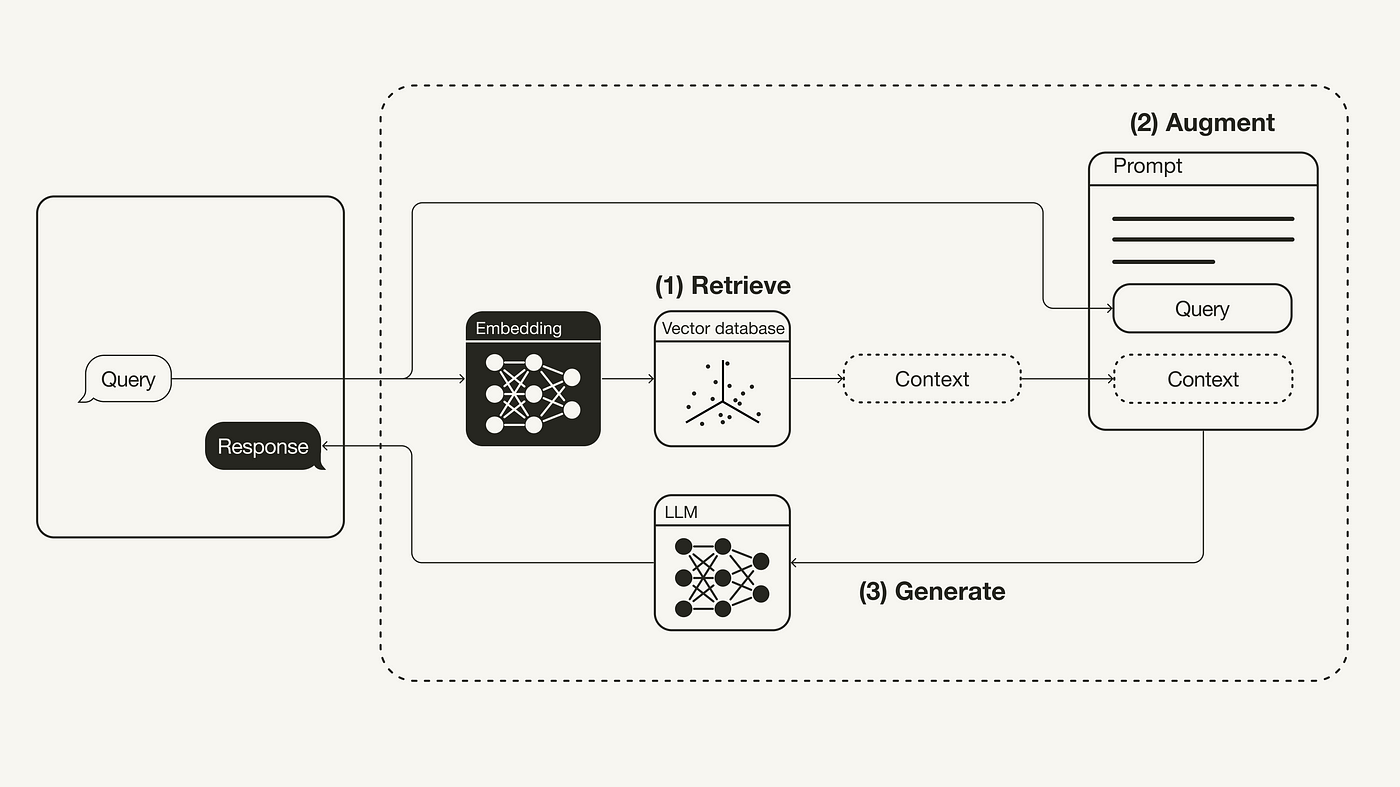

In [15]:
#!pip install langchain
#!pip install langchain-chroma
#!pip install langchain-openai

We need to adapt our documents to the Document format of Langchain, so that we can use the integration of Langchain with Chroma.

In [16]:
from langchain.schema.document import Document

In [17]:
from langchain_openai import AzureOpenAIEmbeddings   
embedding_function=AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment="TextEmbeddings",
    openai_api_version="2024-02-01",
    max_retries=50
)

In [18]:
documents=[]
for i in range(knowledge_base.shape[0]):
    documents.append(Document(page_content=knowledge_base['passages'].iloc[i],metadata={'source':"https://huggingface.co/datasets/rag-datasets/mini-bioasq"}))

By persisting, we do not need to run it again, it saves the data in the folder with the specified directory.

In [19]:
from langchain_chroma import Chroma
db = Chroma.from_documents(documents, embedding_function,persist_directory="./chroma_db")

In [20]:
# load from disk
db = Chroma(persist_directory="./chroma_db", embedding_function=embedding_function)

Let's check the number of tokens in the knowledge base.

In [21]:
# For our ChatGPT model, use this tokenizer
import tiktoken
tokenizer="cl100k_base"
def num_tokens(text: str, model: str = tokenizer) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.get_encoding(tokenizer)
    return len(encoding.encode(text))

In [22]:
knowledge_base['num_tokens']=knowledge_base['passages'].apply(num_tokens)

In [23]:
knowledge_base.head()

,passages,num_tokens
0,New data on viruses isolated from patients wit...,71
1,We describe an improved method for detecting d...,108
2,We have studied the effects of curare on respo...,329
3,Kinetic and electrophoretic properties of 230-...,204
4,Male Wistar specific-pathogen-free rats aged 2...,360


In [24]:
knowledge_base['num_tokens'].sort_values(ascending=False)

29813    8653
37871    6272
39315    6045
39198    5460
20982    5285
         ... 
35164       3
40154       3
36236       3
36269       3
33327       3
Name: num_tokens, Length: 28001, dtype: int64

There are strong variations in the number of tokens. We will keep to one document to make sure we do not go over the maximum of tokens for a request. Nevertheless, there could be many other ideas, such as trying to reduce the number of tokens for those passages, dividing those passages in two or adapting the retrieval to limit the number of tokens before going to the prompt. <br>
Still, let's create a function to retrieve the most similar document (top_n=1).

In [25]:
def search_openai_chroma(query: str) -> list[str]:
    return db.similarity_search(query,1)[0].page_content

In [26]:
search_openai_chroma('papilin')

'α-taxilin is a binding partner of syntaxins, which are the central coordinators \nof membrane traffic. Expression of α-taxilin has been implicated in the \ndevelopment of human glioblastoma, hepatocellular carcinoma and renal cell \ncarcinoma. In the present study, the clinical significance of α-taxilin \nexpression in colorectal cancer (CRC) was investigated. A total of 20 cases of \ncolorectal intramucosal adenocarcinoma (IMA) with adenoma were analyzed using \nimmunohistochemical analysis. The results demonstrated that α-taxilin expression \nwas significantly associated with Ki-67 indices in adenoma and IMA. The patients \nexpressed equally high levels of α-taxilin in the upper third of the \nintramucosal glands. These results suggest that α-taxilin expression is \nsignificantly associated with the proliferative activity of CRC, but that its \noverexpression alone is not a biomarker of malignancy. Next, α-taxilin \nexpression was investigated in 57 advanced CRCs and its association

Now, let's start asking questions!

In [27]:
answer_history=""
model="ChatGPT16k"

In [28]:
client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-02-01"
)

Two functions are defined: query_message and ask. query_message returns the user prompt, formed by the previous answers, the additional context and the current query. If there are not enough tokens, then it starts cutting the oldest answers. The function ask wraps up the process of having a conversation with the chatbot and continues until the user writes 'quit'.

In [29]:
def query_message(
    query: str,
    answer_history: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    """Return a message for GPT, with relevant source texts pulled from a dataframe."""
    string=search_openai_chroma(query)
    answer_history = "# Previous Answers:" +answer_history
    information="\n\n# Document:"
    information+=string
    query = f"\n\n# Current Query: {query}"
    while (
            num_tokens(answer_history + information + query, model=model)
            > token_budget
        ):
            answer_history="# Previous Answers"+answer_history[answer_history.find('Query:',answer_history.find('Query:')+1):]
    message=answer_history
    message+=information
    message+= query
    return message

def ask(
    df: pd.DataFrame = knowledge_base,
    model: str = model,
    token_budget: int = 16000-2112
    ) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings.""" 
    answer_history=""
    while True:
        query=input()
        if query.lower()=="quit":
            break
        message = query_message(query, answer_history, df=df, model=model, token_budget=token_budget)
        messages = [
        {"role": "system", "content": 'You are a question-answering chatbot specialized in biomedicine. Example of a question and the answer you would give: Question - Is RANKL secreted from the cells?; Response - Receptor activator of nuclear factor κB ligand (RANKL) is a cytokine predominantly secreted by osteoblasts. With each user message, you get access to the previous answers (query given by the user and the answer you have given), a document containing information relevant to the question and the actual question of the user.'},
        {"role": "user", "content": message},
        ]
        response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.5,
        max_tokens=2000
        )
        response_message = response.choices[0].message.content
        answer_history=answer_history+"\n\nQuery: "+query+"\n\nAnswer: "+response_message
        print(response_message)

In [30]:
num_tokens('You are a question-answering chatbot specialized in biomedicine. Example of a question and the answer you would give: Question - Is RANKL secreted from the cells?; Response - Receptor activator of nuclear factor κB ligand (RANKL) is a cytokine predominantly secreted by osteoblasts. With each user message, you get access to the previous answers (query given by the user and the answer you have given), a document containing information relevant to the question and the actual question of the user.')

112

In [52]:
ask()

 hello


Hello! How can I assist you today?


 do you have information about papilin?


Papilin is a large extracellular matrix glycoprotein that is involved in the development and maintenance of various tissues in the body. It is encoded by the PAPLN gene. Papilin is primarily expressed in the extracellular matrix of connective tissues, such as skin, cartilage, and blood vessels.

Studies have shown that papilin plays a role in the regulation of cell adhesion, migration, and tissue organization. It interacts with other extracellular matrix proteins, such as collagen and fibronectin, and is involved in the assembly and stabilization of these structures.

In addition to its structural role, papilin has been implicated in various biological processes, including embryonic development, wound healing, and tissue repair. It has also been associated with certain diseases and disorders, such as cancer and connective tissue disorders.

Further research is needed to fully understand the functions and mechanisms of papilin in different tissues and physiological processes.


 what is the name of the protein I have just asked you about?


The protein you asked about is called papilin. It is a large extracellular matrix glycoprotein that is involved in the development and maintenance of various tissues in the body. It is primarily expressed in the extracellular matrix of connective tissues, such as skin, cartilage, and blood vessels. Papilin plays a role in cell adhesion, migration, and tissue organization, and interacts with other extracellular matrix proteins. It is encoded by the PAPLN gene.


 quit


## Evaluation

We will use SAS (semantic answer similarity), utilizing a cross-encoder architecture with the language model cross-encoder/stsb-roberta-large, to evaluate how similar the answers of our chatbot are to the human-annoted in the test dataset. The concept involves using a cross-encoder architecture instead of calculating separate embeddings for the input texts (as in the bi-encoder architecture). In the cross-encoder approach, the two texts are concatenated with a special separator token in between them. According to literature, this metric outperformed lexical-based (e.g. BLEU) and semantic-based (e.g. BERTScore trained) similarity of answer pairs​.  
Check the original [paper](https://arxiv.org/abs/2108.06130) for more information.

In [38]:
#!pip install sentence-transformers

In [39]:
from sentence_transformers import CrossEncoder
model_roberta = CrossEncoder('cross-encoder/stsb-roberta-large')
def cross_encoder_roberta(expected_answer:str, answer: str):
    return model_roberta.predict([expected_answer,answer])

C:\Users\migue\anaconda3\envs\chatbot\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  If the revision to download from cannot be found.


We need to define new functions as now we do not want to incorporate previous answers and we only want one answer for each question in the test.

In [40]:
def query_message_eval(
    query: str,
    df: pd.DataFrame,
    model: str
) -> str:
    """Return a message for GPT, with relevant source texts pulled from a dataframe."""
    string=search_openai_chroma(query)
    information="\n\n# Document:"
    information+=string
    message=information
    message+= query
    return message

In [41]:
def ask_eval(
    query: str,
    df: pd.DataFrame = knowledge_base,
    model: str = model
    ) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings.""" 
    message = query_message_eval(query, df=df, model=model)
    messages = [
        {"role": "system", "content": 'You are a question-answering chatbot specialized in biomedicine. Example of a question and the answer you would give: Question - Is RANKL secreted from the cells?; Response - Receptor activator of nuclear factor κB ligand (RANKL) is a cytokine predominantly secreted by osteoblasts. With each user message, you get access toa document containing information relevant to the question and the actual question of the user.'},
        {"role": "user", "content": message},
        ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.5,
        max_tokens=2000
        )
    response_message = response.choices[0].message.content
    return response_message

We need to remove the example we incorporated in the system prompt.

In [36]:
test.drop(index=4,inplace=True)

In [37]:
test.head()

,question,answer,relevant_passage_ids
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...","[20598273, 6650562, 15829955, 15617541, 230011..."
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,"[23821377, 24323361, 23382875, 22247333, 23787..."
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","[21784067, 19297413, 15094122, 7515725, 332004..."
3,Are long non coding RNAs spliced?,Long non coding RNAs appear to be spliced thro...,"[22955974, 21622663, 22707570, 22955988, 24285..."
5,Does metformin interfere thyroxine absorption?,No. There are not reported data indicating tha...,[26191653]


Now, let's get the answers and the final results.
For simplification, let's use only the first 500 questions.

In [43]:
test=test[:500]

Here, time.sleep() is applied due to rate limit issues.

In [49]:
import time
from openai import RateLimitError

def apply_ask_eval_with_retry(x):
    try:
        return ask_eval(x)
    except RateLimitError:
        time.sleep(5)
        return apply_ask_eval_with_retry(x)

In [50]:
test['chat_answer'] = test["question"].apply(lambda x: apply_ask_eval_with_retry(x))

In [51]:
test['sas']=test.apply(lambda x:cross_encoder_roberta(x['answer'],x['chat_answer']),axis=1)

In [60]:
test.head()

,question,answer,relevant_passage_ids,chat_answer,sas
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...","[20598273, 6650562, 15829955, 15617541, 230011...",Hirschsprung disease is considered to be a mul...,0.659204
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,"[23821377, 24323361, 23382875, 22247333, 23787...",The ligands that interact with the receptor EG...,0.810020
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","[21784067, 19297413, 15094122, 7515725, 332004...",There is no information in the provided docume...,0.539275
3,Are long non coding RNAs spliced?,Long non coding RNAs appear to be spliced thro...,"[22955974, 21622663, 22707570, 22955988, 24285...","Yes, according to the provided document, long ...",0.814545
5,Does metformin interfere thyroxine absorption?,No. There are not reported data indicating tha...,[26191653],The document does not provide information abou...,0.898746


In [62]:
test['sas'].max()

0.9719775

In [63]:
test[test['sas']==0.9719775]

,question,answer,relevant_passage_ids,chat_answer,sas
280,How many genera comprise the Flaviviridae family?,The family Flaviviridae is comprised of three ...,"[22513121, 18991746, 8396675, 16225688, 204702...",The Flaviviridae family comprises three genera...,0.971977


In [65]:
test['answer'].loc[280]

'The family Flaviviridae is comprised of three genera: Flavivirus, Pestivirus and Hepacivirus.'

In [66]:
test['chat_answer'].loc[280]

'The Flaviviridae family comprises three genera: Flavivirus, Hepacivirus, and Pestivirus.'

In [61]:
test['sas'].min()

0.012481533

In [68]:
test[test['sas']==0.012481533]

,question,answer,relevant_passage_ids,chat_answer,sas
193,List human proteins that are subject to a dime...,GAC\nSHMT2\nAMPAR\nOrai1\nOrai3,"[25548170, 23739980, 25619277, 21080238, 21987...","I'm sorry, but the document you provided does ...",0.012482


In [69]:
test['answer'].loc[193]

'GAC\nSHMT2\nAMPAR\nOrai1\nOrai3'

In [70]:
test['chat_answer'].loc[193]

"I'm sorry, but the document you provided does not contain information about human proteins that undergo a dimer-to-tetramer transition."

In [67]:
test['sas'].mean()

0.64592826

There are many ways to improve this performance. Like other data science tasks, many experiments should be conducted to optimize the performance level of the model.